## Script's Goals

This script is used to classify the pre-processed transcriptomic data into 3 classes : Healthy, RA, or SLE. The input file is an anndata object.

 ## Import packages

In [2]:
# Data Handling and Processing
import pandas as pd
import anndata as ad
import scanpy as sc
import numpy as np

# Machine Learning and Model Evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Hyperparameter Testing and Interpretability
import shap
from sklearn.exceptions import ConvergenceWarning
import warnings

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap

# Gene Set Enrichment Analysis
import gseapy as gp

# Utility
from tqdm import tqdm  # To view loop progress (optional)

2025-01-15 18:55:48.052542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-15 18:55:48.065215: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-15 18:55:48.069170: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 18:55:48.079466: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Define Function

In [10]:
def prepare_NN(y_train, y_test):
    """function to transform the labels into numeric codes for sklearn"""
    
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    
    # Fit the encoder on the training data and transform both train and test labels
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Return the encoded labels as numpy arrays
    return y_train_encoded, y_test_encoded

In [11]:
def create_model_MLPC(hidden_layer_sizes=(100,), activation='relu', dropout_rate=None, solver='adam', max_iter=300):
    """
    Function to define the architecture of the neural network using sklearn's MLPClassifier.

    Parameters:
    - hidden_layer_sizes (tuple): Number of neurons in each hidden layer (e.g., (64, 64) for two layers of 64 neurons).
    - activation (str): Activation function to use ('relu', 'tanh', 'logistic').
    - dropout_rate (float): Not directly supported in MLPClassifier. Consider alternatives in preprocessing.
    - solver (str): Optimizer to use ('adam', 'sgd', 'lbfgs').
    - max_iter (int): Maximum number of iterations for training.

    Returns:
    - MLPClassifier: Configured MLP model ready for training.
    """
    if dropout_rate is not None:
        print("Warning: Dropout is not natively supported in MLPClassifier. Consider implementing it manually.")

    # Define the MLPClassifier with the given parameters
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        max_iter=max_iter,
        random_state=42
    )
    return model

In [12]:
def create_model_MLPC_test(hidden_layer_sizes=1, neurone_layer=100, activation='relu', dropout_rate=None, solver='adam', max_iter=300, learning_rates='constant'):
    """
    Function to define the architecture of a neural network using sklearn's MLPClassifier.

    Parameters:
    - hidden_layer_sizes (int): Number of layers in the neural network.It determines how many times the neurone_layer value will be repeated.
    - neurone_layer (int): Number of neurons in each hidden layer.
    - activation (str): The activation function to use for the hidden layers. It can be one of ['relu', 'tanh', 'logistic']. Default is 'relu'.
    - dropout_rate (float, optional): The dropout rate to apply, but it is not directly supported in MLPClassifier. A warning is shown if this is used.
    - solver (str): The solver to use for weight optimization. Possible values are ['adam', 'sgd', 'lbfgs']. Default is 'adam'.
    - max_iter (int): The maximum number of iterations for training the model. Default is 300.
    - learning_rates (str): The learning rate for training. Can be a fixed value or 'constant', 'invscaling', or 'adaptive'.

    Returns:
    - MLPClassifier: A configured MLP model ready for training.

    Note:
    - Dropout is not supported by MLPClassifier, so it is recommended to manually handle this, 
      or use preprocessing steps to simulate dropout.
    """
    if dropout_rate is not None:
        print("Warning: Dropout is not natively supported in MLPClassifier. Consider implementing it manually.")
        
    # Define the MLPClassifier with the given parameters
    model = MLPClassifier(
        hidden_layer_sizes=(neurone_layer,) * hidden_layer_sizes,  # Repeat neurone_layer 'hidden_layer_sizes' times to define the number of layers
        activation=activation,  # Set the activation function
        solver=solver,  # Choose the solver for optimization
        max_iter=max_iter,  # Set the maximum number of training iterations
        learning_rate= learning_rates,  # Set the learning rate
        random_state=42  # Ensure reproducibility by setting a random seed
    )
    return model


In [13]:
def create_model_RF(n_est = 100, max_d = None, min_leaf= 1, min_split= 2):
    
    # Define the RandomForestClassifier with the given parameters
    model = RandomForestClassifier(
        n_estimators=n_est, 
        max_depth = max_d, 
        min_samples_leaf= min_leaf, 
        min_samples_split= min_split,
        random_state=42
        )
    return model
    
    

In [14]:
def prepare_shap(adata):
    """function to prepare a small dataset containing samples from each health_status in the same proportion, to then determined"""
    # the genes that are importants for the classification
    adata_h = adata[adata.obs["status"] == "healthy"][:30]
    adata_ra = adata[adata.obs["status"] == "ra"][:30]
    adata_sle = adata[adata.obs["status"] == "sle"][:30]
    
    list_adata = [adata_h,adata_ra,adata_sle]
    
    adata_shap = ad.concat(list_adata)
    
    return adata_shap
    

In [15]:
def perform_shap(adata):
    """function to perform the shap analysis to get the most importants genes for the classification of health_status"""
    
    X_shap = adata.X
    sample_data = X_shap.toarray() if hasattr(X_shap, "toarray") else X_shap
    
    # get the gene names
    gene_names = adata.var_names.tolist()


    # Create the SHAP explainer for the Keras model
    explainer = shap.DeepExplainer(model, sample_data)

    # Calculate SHAP values for a subset of data
    shap_values = explainer.shap_values(sample_data)
    
    return shap_values, sample_data, gene_names


In [16]:
def give_importance(shap_values, i):
    shap_importance = np.abs(shap_values[i].T).mean(axis=0)

    # Créer un DataFrame pour faciliter la manipulation (en supposant que gene_names est la liste des noms de gènes)
    shap_df = pd.DataFrame({
        'gene': gene_names,
        'importance': shap_importance
    })

    # Trier les gènes par importance décroissante et récupérer les 10 premiers
    top_10_genes = shap_df.sort_values(by='importance', ascending=False).head(10)['gene'].tolist()

    # Afficher ou utiliser la liste des 10 gènes les plus importants
    return top_10_genes

## Load the data

In [104]:
adata = ad.read_h5ad("/home/mc202900/outputs/Dataset_PP_500")

## Split the anndata object into a train object, a dev object and a test object

In [105]:
# Train object
adata_train = adata[adata.obs["role"] == "train"].copy()

#Test object
adata_test = adata[adata.obs["role"] == "test"].copy()


labels_train = adata_train.obs["status"]  # Extraction of health status
labels_test = adata_test.obs["status"]  # Extraction of health status

print(type(labels_train[0]))

y_train, y_test = prepare_NN(labels_train, labels_test) # encode the labels

# Extract expression values
X_train = adata_train.X
X_test = adata_test.X

# Random split of X_test and y_test to obtain a development set (to optimize hyperparameters) and a final test set (to check the performance of our best model at the very end)
X_dev, X_test_final, y_dev, y_test_final = train_test_split(
    X_test, y_test, test_size=1/3, stratify=y_test, random_state=42
)


<class 'str'>


/tmp/ipykernel_1923236/3327994014.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(type(labels_train[0]))


# Perform the Machine Learning

## Logistic Regression

In [58]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the classification model
model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train_scaled, labels_train)

# Predict on the test dataset
y_pred = model.predict(X_test_scaled)

# Display the classification report
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00       100
          ra       0.69      0.95      0.80       330
         sle       0.96      0.70      0.81       465

    accuracy                           0.83       895
   macro avg       0.88      0.88      0.87       895
weighted avg       0.86      0.83      0.83       895



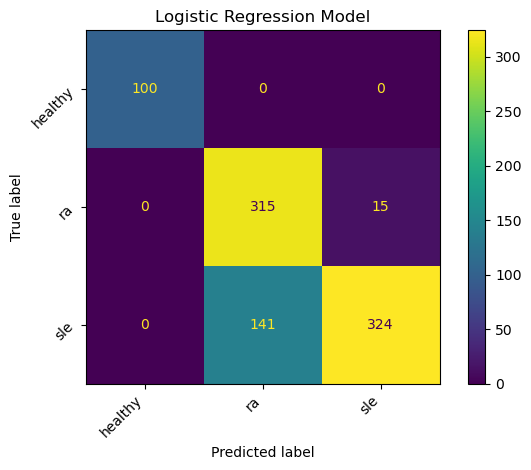

In [61]:
# Confusion matrix
cm_log_regression = confusion_matrix(labels_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_regression, display_labels=model.classes_)
disp.plot()

# Adjust layout
plt.title('Logistic Regression Model')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

## Random Forest

#### Test des hyperparamètres

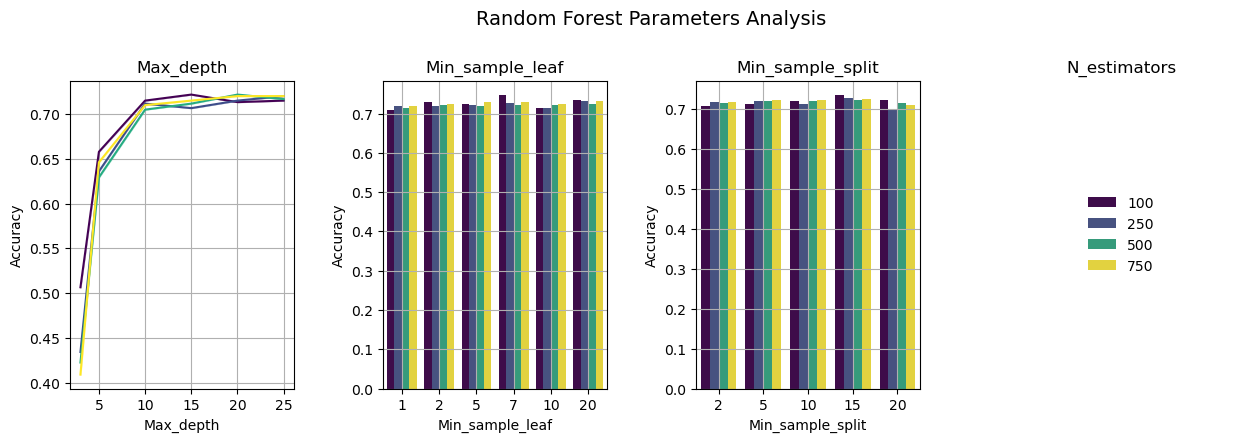

In [ ]:
fig1, axes = plt.subplots(1,4, figsize=(15, 4))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

structure = [100, 250, 500, 750]

# ## PROFONDEUR MAXIMALE
# Analyse de l'effet de la profondeur maximale
errD = []
max_depths = [3, 5, 10, 15, 20, 25]
print("\nMax_depths")
for struc in (structure):
    print(f"Structure : {struc} neurones")
    for profondeur in tqdm(max_depths):
        for replicate in range(3):
            # Create the model
            mdl = create_model_RF(n_est = struc ,max_d = profondeur)
            # Train the model
            mdl.fit(X_train, y_train)
            # Check the performance
            accuracy = mdl.score(X_dev, y_dev)
            errD.append({'Max_depths': profondeur, 'Accuracy': accuracy,'Structure': struc})
            
dataDepth = pd.DataFrame(errD)
#plot the data
sns.lineplot(x='Max_depths', y='Accuracy', hue = 'Structure',data=dataDepth,errorbar=('ci', 95), palette='viridis', ax=axes[0])
axes[0].set_title('Max_depth')
axes[0].set_xlabel('Max_depth')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True)
axes[0].legend().remove()

# ## NOMBRE MINIMUM D'ECHANTILLONS PAR FEUILLES
# Analyse de l'effet du nombre minimum d'échantillons par feuille
errL = []
Leaf = [1, 2, 5, 7, 10, 20]
print("\nMin_sample_leaf")
for struc in (structure):
    print(f"Structure : {struc} neurones")
    for min_leaf in tqdm (Leaf):
        for replicate in range(3):
            # Create the model
            mdl = create_model_RF(n_est = struc, min_leaf = min_leaf)
            # Train the model
            mdl.fit(X_train, y_train)
            # Check the performance
            accuracy = mdl.score(X_dev, y_dev)
            errL.append({'Min Leaf': min_leaf, 'Accuracy': accuracy, 'Structure': struc})
dataLeaf = pd.DataFrame(errL)

#plot the data
sns.barplot(x='Min Leaf', y='Accuracy', hue = 'Structure', data=dataLeaf, ax=axes[1], palette='viridis')
axes[1].set_title("Min_sample_leaf")
axes[1].set_xlabel('Min_sample_leaf')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)

axes[1].annotate("Random Forest Parameters Analysis", 
             fontsize=14, 
             xy=(1.2, 1.2), 
             xycoords='axes fraction',  
             ha='center',  
             va='center')



# ## MINIMUM D'ECHANTILLONS POUR DIVISER UN NOEUD
# Analyse de l'effet du nombre minimum d'échantillons pour diviser un noeud
errS = []
min_split = [2, 5, 10, 15, 20]
print("\nmin_split")
for struc in (structure):
    print(f"Structure : {struc} neurones")
    for split in tqdm (min_split):
        for replicate in range(3):
            # Create the model
            mdl = create_model_RF(n_est = struc, min_split = split)
            # Train the model
            mdl.fit(X_train, y_train)
            # Check the performance
            accuracy = mdl.score(X_dev, y_dev)
            errS.append({'Min_split': split, 'Accuracy': accuracy, 'Structure': struc})
dataSplit = pd.DataFrame(errS)

#plot the data
sns.barplot(x='Min_split', y='Accuracy', hue= 'Structure',data=dataSplit, ax=axes[2],palette='viridis')
axes[2].set_title("Min_sample_split")
axes[2].set_xlabel('Min_sample_split')
axes[2].set_ylabel('Accuracy')
axes[2].grid(True)
axes[2].legend().remove()


# Extraire la légende et l'afficher dans le dernier cadran
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend().remove() # Supprimer la légende du premier cadran
axes[3].legend(handles, labels, loc='center', frameon=False)
axes[3].axis('off')  # Désactiver les axes du dernier cadran
axes[3].set_title("N_estimators", fontsize=12) 

plt.show()

The previous results indicate that the 100-node structure seems to be optimal. For the other parameters, max_depth must be at least 10, min_sample_leaf 7 and min_sample_split 15. 

In [140]:
# Train the classification model
model = create_model_RF(n_est=100, min_leaf=7, min_split=2, max_d=None)
model.fit(X_train, labels_train)

# Predict on the test dataset
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)  # Get probabilities for each class

# Stock predictions in adata_test
adata_test.obs['pred'] = y_pred


# Display the classification report
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

     healthy       1.00      0.99      0.99       100
          ra       0.60      1.00      0.75       330
         sle       1.00      0.52      0.69       465

    accuracy                           0.75       895
   macro avg       0.87      0.84      0.81       895
weighted avg       0.85      0.75      0.74       895



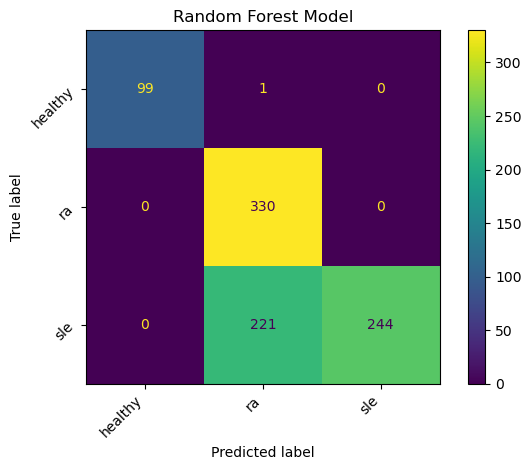

In [141]:
cm_RF = confusion_matrix(labels_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF, display_labels=model.classes_)
disp.plot()

# Adjust the rotation of the x-axis labels and y-axis labels
plt.title("Random Forest Model")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()

Healthy status is perfectly predicted. RA and SLE are predicted with a good f1-score (0.73 and 0.79, respectively). The model is overall performant (accuracy = 0.73), but it often predicts SLE samples as RA samples (242 mistakes).

Gene IFI44 importance: 0.025102410004097277
Gene HBA2 importance: 0.022819170528533324
Gene HBB importance: 0.021882644919906116
Gene IFI27 importance: 0.021416081899581683
Gene TPX2 importance: 0.014386578731920356
Gene CD177 importance: 0.01401427079593271
Gene IFI44L importance: 0.013245885123198985
Gene MB importance: 0.012701479747024574
Gene HBQ1 importance: 0.011702965669236563
Gene OAS3 importance: 0.011303212017456592


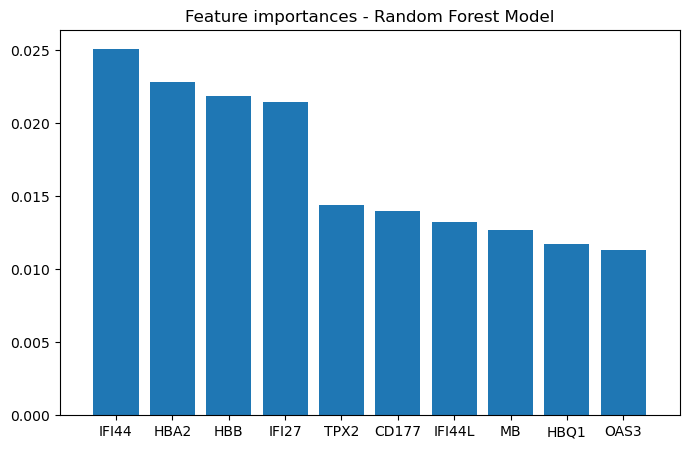

In [142]:
# Observe the most important features of the model
importances = model.feature_importances_

# get genes names

gene_names = adata.var_names.tolist()
most_important_gene_name = []

# Display the 10 most important features
indices = np.argsort(importances)[::-1]
for i in range(10):
    print(f"Gene {gene_names[indices[i]]} importance: {importances[indices[i]]}")
    most_important_gene_name.append(gene_names[indices[i]])

plt.figure(figsize=(8, 5))
plt.title("Feature importances - Random Forest Model" )
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), most_important_gene_name[:10])
plt.xlim([-1, 10])
plt.show()

In [70]:
# Enrichment analysis to find associated pathways

enrichment_results = gp.enrichr(gene_list=most_important_gene_name,
                                gene_sets="KEGG_2016", 
                                organism='Human',     
                                outdir=None)            

# Display results
print(enrichment_results.results.head(10))  # Affiche les 10 pathways les plus significatifs

    Gene_set                                               Term Overlap  \
0  KEGG_2016      African trypanosomiasis Homo sapiens hsa05143    2/35   
1  KEGG_2016                      Malaria Homo sapiens hsa05144    2/49   
2  KEGG_2016  Arrhythmogenic right ventricular cardiomyopath...    1/74   
3  KEGG_2016  Hypertrophic cardiomyopathy (HCM) Homo sapiens...    1/83   
4  KEGG_2016       Dilated cardiomyopathy Homo sapiens hsa05414    1/90   
5  KEGG_2016                  Hepatitis C Homo sapiens hsa05160   1/133   
6  KEGG_2016                      Measles Homo sapiens hsa05162   1/136   
7  KEGG_2016                  Influenza A Homo sapiens hsa05164   1/175   
8  KEGG_2016     Herpes simplex infection Homo sapiens hsa05168   1/185   

    P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0  0.000133          0.001176            0                     0  151.189394   
1  0.000261          0.001176            0                     0  106.079787   
2  0.0363

Only 3 pathways detected. HBB and HBA2 have 2 pathways in common. But the name of the pathways are not really relevants.

In [71]:
# Enrichment analysis for GO term : Biological Process

enrichment_results = gp.enrichr(gene_list=most_important_gene_name,
                                gene_sets='GO_Biological_Process_2018', 
                                organism='Human',
                                outdir=None)

# Display results
print(enrichment_results.results[['Term', 'Adjusted P-value', 'Genes']].head(10))

                                                Term  Adjusted P-value  \
0                      oxygen transport (GO:0015671)           0.00042   
1                         gas transport (GO:0015669)           0.00045   
2  cellular response to type I interferon (GO:007...           0.01024   
3   type I interferon signaling pathway (GO:0060337)           0.01024   
4       regulation of nuclease activity (GO:0032069)           0.03451   
5              neutrophil extravasation (GO:0072672)           0.03451   
6                 granulocyte migration (GO:0097530)           0.03451   
7             cell junction maintenance (GO:0034331)           0.03451   
8  positive regulation of myeloid leukocyte media...           0.03451   
9        cell-cell junction maintenance (GO:0045217)           0.03451   

        Genes  
0      MB;HBB  
1      MB;HBB  
2  IFI27;OAS3  
3  IFI27;OAS3  
4        OAS3  
5       CD177  
6       CD177  
7       CD177  
8       CD177  
9       CD177  


Only HBB and APOD have BP in common. There is a lot of genes which have a BP linked to inflammatory/ immune response (e.g. GO term with lymphocyte, neutrophil, monocyte...). This may make sense to identify RA and SLE diseases.

## Neural Network

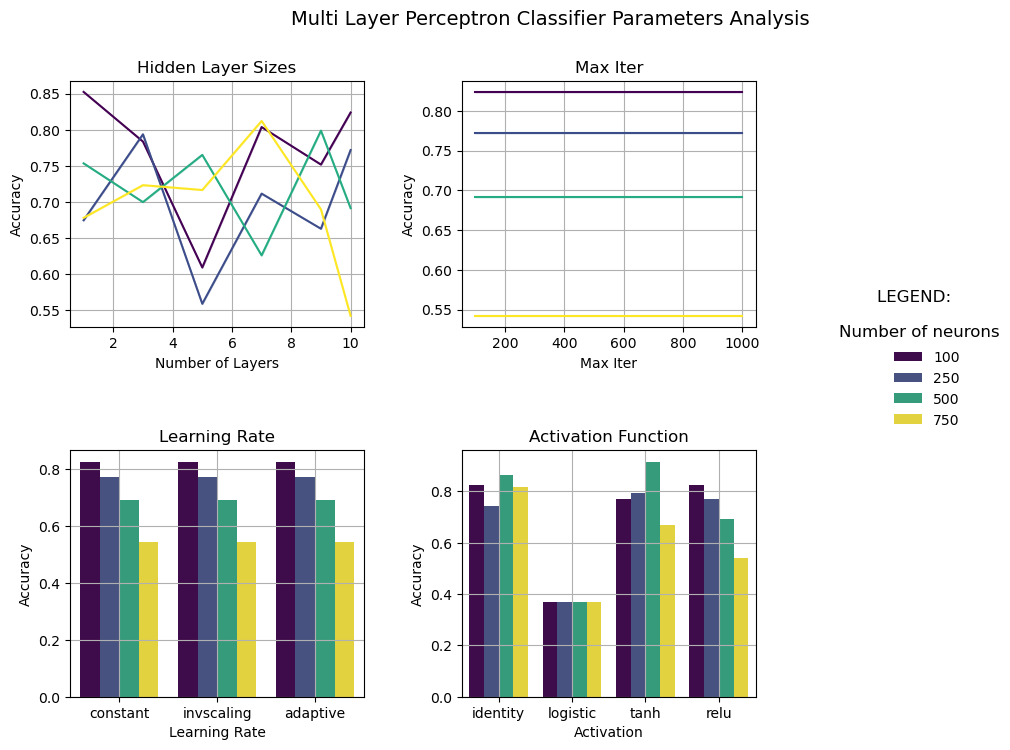

In [ ]:
#Supprime les messages de convergences pour les tests du nombre de neurones par couches 
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm


fig3 = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.5]) 
plt.subplots_adjust(hspace=0.5, wspace=0.4)

structure = [100, 250, 500, 750]

# 1. Nombre de couches cachées
errC = []
couches = [1, 3, 5, 7, 9, 10]
print("\nhidden_layer_sizes")
for struc in structure:
    for couche in tqdm(couches):
        for replicate in range(3):
            mdl = create_model_MLPC_test(hidden_layer_sizes=couche, neurone_layer=int(struc/couche))
            mdl.fit(X_train, y_train)
            accuracy = mdl.score(X_dev, y_dev)
            errC.append({'Couches': couche, 'Accuracy': accuracy, 'Structure': struc})
dataCouche = pd.DataFrame(errC)

ax1 = fig3.add_subplot(gs[0, 0])
sns.lineplot(x='Couches', y='Accuracy', hue='Structure', data=dataCouche, errorbar=('ci', 95), palette='viridis', ax=ax1)
ax1.set_title('Hidden Layer Sizes')
ax1.set_xlabel('Number of Layers')
ax1.set_ylabel('Accuracy')
ax1.grid(True)
ax1.legend().remove()

# 2. Fonction d'activation
errA = []
activations = ['identity', 'logistic', 'tanh', 'relu']
print("\nActivation Function")
for struc in structure:
    for activation in tqdm(activations):
        for replicate in range(3):
            mdl = create_model_MLPC_test(hidden_layer_sizes=10, neurone_layer=int(struc/10), activation=activation)
            mdl.fit(X_train, y_train)
            accuracy = mdl.score(X_dev, y_dev)
            errA.append({'Activation': activation, 'Accuracy': accuracy, 'Structure': struc})
dataActivation = pd.DataFrame(errA)

ax2 = fig3.add_subplot(gs[1, 1])
sns.barplot(x='Activation', y='Accuracy', hue='Structure', data=dataActivation, palette='viridis', ax=ax2)
ax2.set_title('Activation Function')
ax2.set_xlabel('Activation')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend().remove()

# 3. Learning rate
errL = []
learning_rates = ['constant', 'invscaling', 'adaptive']
print("\nLearning Rate")
for struc in structure:
    for lr in tqdm(learning_rates):
        for replicate in range(3):
            mdl = create_model_MLPC_test(hidden_layer_sizes=10, neurone_layer=int(struc/10), learning_rates=lr)
            mdl.fit(X_train, y_train)
            accuracy = mdl.score(X_dev, y_dev)
            errL.append({'Learning Rate': lr, 'Accuracy': accuracy, 'Structure': struc})
dataLearningRate = pd.DataFrame(errL)

ax3 = fig3.add_subplot(gs[1, 0])
sns.barplot(x='Learning Rate', y='Accuracy', hue='Structure', data=dataLearningRate, palette='viridis', ax=ax3)
ax3.set_title('Learning Rate')
ax3.set_xlabel('Learning Rate')
ax3.set_ylabel('Accuracy')
ax3.grid(True)
ax3.legend().remove()

# 4. Max iterations
errI = []
max_iters = np.linspace(100, 1000, 10).astype(int)
print("\nMax_iter")
for struc in structure:
    for max_iter in tqdm(max_iters):
        for replicate in range(3):
            mdl = create_model_MLPC_test(hidden_layer_sizes=10, neurone_layer=int(struc/10), max_iter=max_iter)
            mdl.fit(X_train, y_train)
            accuracy = mdl.score(X_dev, y_dev)
            errI.append({'Max Iter': max_iter, 'Accuracy': accuracy, 'Structure': struc})
dataMaxIter = pd.DataFrame(errI)

ax4 = fig3.add_subplot(gs[0, 1])
sns.lineplot(x='Max Iter', y='Accuracy', hue='Structure', data=dataMaxIter, errorbar=('ci', 95), palette='viridis', ax=ax4)
ax4.set_title('Max Iter')
ax4.set_xlabel('Max Iter')
ax4.set_ylabel('Accuracy')
ax4.grid(True)
ax4.legend().remove()

ax4.annotate("Multi Layer Perceptron Classifier Parameters Analysis", 
             fontsize=14, 
             xy=(0.3, 1.25), 
             xycoords='axes fraction',  
             ha='center',  
             va='center')

# Légende globale
ax5 = fig3.add_subplot(gs[:, 2])
handles, labels = ax3.get_legend_handles_labels()
ax1.legend().remove()
ax5.legend(handles, labels, loc='center', frameon=False)
ax5.axis('off')
ax5.annotate("LEGEND:  \n \nNumber of neurons", 
             fontsize=12, 
             xy=(0.45, 0.62), 
             xycoords='axes fraction',  
             ha='center',  
             va='center')

plt.show()


In [108]:
# Set the best model
model = create_model_MLPC((10, 30, 10), activation='relu', dropout_rate=None, solver='adam', max_iter=300)

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate performance with the best model
accuracy = model.score(X_test_final, y_test_final)
print("Accuracy:", accuracy)

y_pred = model.predict(X_test)

Accuracy: 0.939799331103679


In [109]:
target_names = ['healthy', 'ra', 'sle']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     healthy       0.99      1.00      1.00       100
          ra       0.91      0.95      0.93       330
         sle       0.96      0.94      0.95       465

    accuracy                           0.95       895
   macro avg       0.95      0.96      0.96       895
weighted avg       0.95      0.95      0.95       895



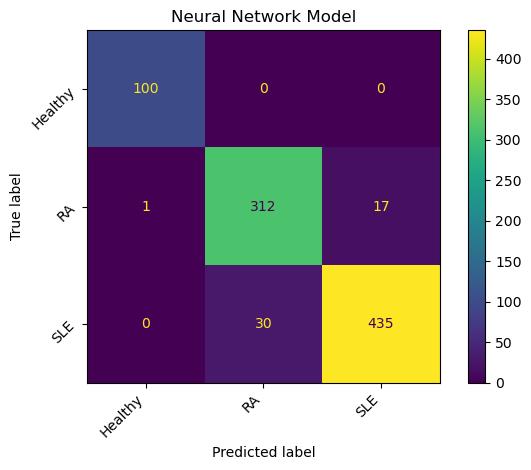

In [110]:
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "RA", "SLE"])
disp.plot()

# Adjust the rotation of the x-axis labels and y-axis labels
plt.title('Neural Network Model')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()

Healthy status is perfectly predicted. RA and SLE are predicted with a good f1-score (0.83 for both). The model is overall performant (accuracy = 0.85) and better than the RF model, but it also often predicts SLE samples as RA samples (130 mistakes).

### Visualize the features importances

  0%|          | 0/10 [00:00<?, ?it/s]

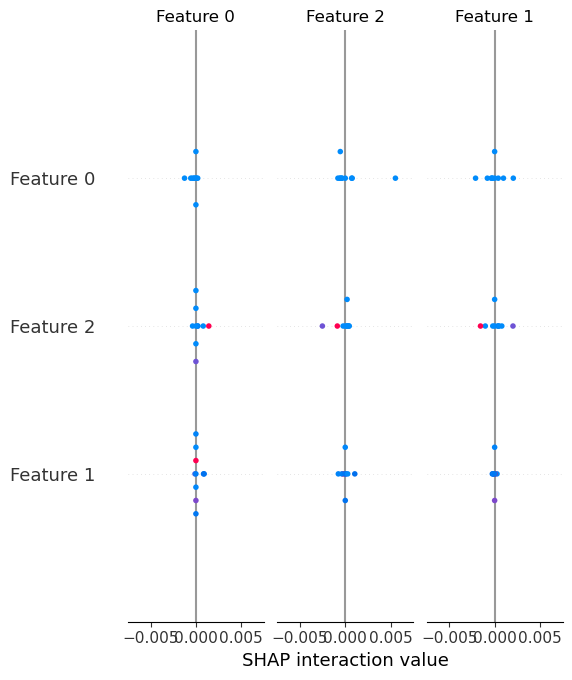

In [111]:
# Utiliser KernelExplainer
explainer = shap.KernelExplainer(model.predict_proba, X_train[:100])  # Echantillon pour l'explainer
shap_values = explainer.shap_values(X_test[:10])  # SHAP values sur un sous-ensemble
shap.summary_plot(shap_values, X_test[:10])